In [1]:
from paren_2 import *
import pickle
from torch.utils.data import DataLoader, TensorDataset

In [2]:
with open('model_mask_paren_4_dec_maxlen_100_probable.pkl', 'rb') as f:
    model = pickle.load(f)

In [3]:
tokeniser = SimpleTokenizer("()")

In [4]:
output, internal = model(tokeniser.tokenize("()").to(device), return_states=True)
print(internal.shape)

torch.Size([1, 4, 56])


In [5]:
def generate_parentheses(n):
    def backtrack(s='', left=0, right=0):
        if len(s) == 2 * n:
            result.append(s)
            return
        if left < n:
            backtrack(s + '(', left + 1, right)
        if right < left:
            backtrack(s + ')', left, right + 1)

    result = []
    backtrack()
    return result

In [6]:
sizes = [4, 8]
paren = []
for size in sizes:
    paren.extend(generate_parentheses(size))
    print("size", size, "done")

size 4 done
size 8 done


In [7]:
paren_tokens = [tokeniser.tokenize(p) for p in paren]

In [8]:
assert len(paren_tokens) == len(paren)
print(len(paren_tokens))

1444


In [9]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
START = 0
PAD = 1
END = 2
OPEN = 3
CLOSE = 4

In [11]:
def simulate_stack(tokenised_paren):
    stack = []
    stack_depths = []
    for token in tokenised_paren[0]:
        if token == OPEN:
            stack.append(token)
        elif token == CLOSE:
            stack.pop()
        stack_depths.append(len(stack))
    return stack_depths

def create_dataset(model, paren_tokens, device="mps"):
    X = []
    Y = []

    model.eval()

    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            output, internal = model(tokenised_paren.to(device), return_states=True)
            internal = internal.squeeze(0)
            stack_depths = simulate_stack(tokenised_paren)
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(stack_depths[i])
    return X, Y

In [22]:
def create_identity_dataset(model, paren_tokens, device="mps"):
    X = []
    Y = []

    model.eval()

    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            output, internal = model(tokenised_paren.to(device), return_states=True)
            internal = internal.squeeze(0)
            stack_depths = simulate_stack(tokenised_paren)
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(tokenised_paren[0][i].item())
    return X, Y

In [12]:
X, Y = create_dataset(model, paren_tokens)

In [23]:
X_id, Y_id = create_identity_dataset(model, paren_tokens, device="mps")

In [13]:
X[0].shape

(56,)

In [14]:
class ProbingClassifer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ProbingClassifer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [15]:
probing_model = ProbingClassifer(56, 1).to(device)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device).unsqueeze(1)

dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(probing_model.parameters(), lr=0.001)

/var/folders/1c/pssfr1c910ncsn52rc0ypzzc0000gn/T/ipykernel_17851/1629473663.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  X_tensor = torch.tensor(X, dtype=torch.float32).to(device)


In [27]:
probing_model_id = ProbingClassifer(56, 5).to(device)
X_tensor_id = torch.tensor(X_id, dtype=torch.float32).to(device)
Y_tensor_id = torch.tensor(Y_id, dtype=torch.float32).to(device).unsqueeze(1)

dataset_id = TensorDataset(X_tensor_id, Y_tensor_id)
dataloader_id = DataLoader(dataset_id, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(probing_model.parameters(), lr=0.001)

In [28]:
num_epochs = 30
acc = []
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    probing_model_id.train()
    for inputs, targets in dataloader_id:
        optimizer.zero_grad()
        outputs = probing_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = outputs.round()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    acc.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/30], Loss: 0.4700, Accuracy: 0.8718
Epoch [2/30], Loss: 0.4700, Accuracy: 0.8872
Epoch [3/30], Loss: 0.4702, Accuracy: 0.8803
Epoch [4/30], Loss: 0.4700, Accuracy: 0.8749
Epoch [5/30], Loss: 0.4698, Accuracy: 0.8700
Epoch [6/30], Loss: 0.4696, Accuracy: 0.8833
Epoch [7/30], Loss: 0.4701, Accuracy: 0.8863
Epoch [8/30], Loss: 0.4698, Accuracy: 0.8873
Epoch [9/30], Loss: 0.4695, Accuracy: 0.8825
Epoch [10/30], Loss: 0.4691, Accuracy: 0.8787
Epoch [11/30], Loss: 0.4703, Accuracy: 0.8837
Epoch [12/30], Loss: 0.4698, Accuracy: 0.8738
Epoch [13/30], Loss: 0.4696, Accuracy: 0.8862
Epoch [14/30], Loss: 0.4699, Accuracy: 0.8815
Epoch [15/30], Loss: 0.4698, Accuracy: 0.8837
Epoch [16/30], Loss: 0.4703, Accuracy: 0.8778
Epoch [17/30], Loss: 0.4699, Accuracy: 0.8834
Epoch [18/30], Loss: 0.4696, Accuracy: 0.8847
Epoch [19/30], Loss: 0.4701, Accuracy: 0.8808
Epoch [20/30], Loss: 0.4696, Accuracy: 0.8873
Epoch [21/30], Loss: 0.4696, Accuracy: 0.8764
Epoch [22/30], Loss: 0.4699, Accuracy: 0.87

In [16]:
num_epochs = 30
acc = []
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    probing_model.train()
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = probing_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = outputs.round()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    acc.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/30], Loss: 1.5794, Accuracy: 0.2872
Epoch [2/30], Loss: 1.5200, Accuracy: 0.2909
Epoch [3/30], Loss: 1.5147, Accuracy: 0.2894
Epoch [4/30], Loss: 1.5074, Accuracy: 0.2871
Epoch [5/30], Loss: 1.5053, Accuracy: 0.2871
Epoch [6/30], Loss: 1.4984, Accuracy: 0.2886
Epoch [7/30], Loss: 1.4966, Accuracy: 0.2855
Epoch [8/30], Loss: 1.4992, Accuracy: 0.2863
Epoch [9/30], Loss: 1.4954, Accuracy: 0.2874
Epoch [10/30], Loss: 1.4942, Accuracy: 0.2897
Epoch [11/30], Loss: 1.4929, Accuracy: 0.2854
Epoch [12/30], Loss: 1.4923, Accuracy: 0.2877
Epoch [13/30], Loss: 1.4884, Accuracy: 0.2874
Epoch [14/30], Loss: 1.4861, Accuracy: 0.2917
Epoch [15/30], Loss: 1.4869, Accuracy: 0.2881
Epoch [16/30], Loss: 1.4867, Accuracy: 0.2910
Epoch [17/30], Loss: 1.4853, Accuracy: 0.2904
Epoch [18/30], Loss: 1.4846, Accuracy: 0.2927
Epoch [19/30], Loss: 1.4854, Accuracy: 0.2883
Epoch [20/30], Loss: 1.4847, Accuracy: 0.2868
Epoch [21/30], Loss: 1.4832, Accuracy: 0.2873
Epoch [22/30], Loss: 1.4828, Accuracy: 0.29

In [17]:
VOCAB = {"[pad]": 1, "[start]": 0, "[end]": 2, "(": 3, ")": 4}
EPOCHS = 30
device = "mps"
model_untrained = BalancedParenthesesModel(len(VOCAB), HIDDEN_SIZE, MAX_LEN, NUM_LAYERS, NUM_HEADS).to(device)
X_untrained, Y_untrained = create_dataset(model_untrained, paren_tokens)
X_untrained_tensor = torch.tensor(X_untrained, dtype=torch.float32).to(device)
Y_untrained_tensor = torch.tensor(Y_untrained, dtype=torch.float32).to(device).unsqueeze(1)
dataset_untrained = TensorDataset(X_untrained_tensor, Y_untrained_tensor)
dataloader_untrained = DataLoader(dataset_untrained, batch_size=BATCH_SIZE, shuffle=True)
probing_model_untrained = ProbingClassifer(56, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(probing_model_untrained.parameters(), lr=0.001)
acc_untrained = []
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    
    probing_model_untrained.train()
    for inputs, targets in dataloader_untrained:
        optimizer.zero_grad()
        outputs = probing_model_untrained(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = outputs.round()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    avg_loss = total_loss / len(dataloader_untrained)
    accuracy = correct / total
    acc_untrained.append(accuracy)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/30], Loss: 1.2820, Accuracy: 0.3856
Epoch [2/30], Loss: 1.2594, Accuracy: 0.3873
Epoch [3/30], Loss: 1.2574, Accuracy: 0.3909
Epoch [4/30], Loss: 1.2569, Accuracy: 0.3898
Epoch [5/30], Loss: 1.2587, Accuracy: 0.3918
Epoch [6/30], Loss: 1.2567, Accuracy: 0.3894
Epoch [7/30], Loss: 1.2574, Accuracy: 0.3910
Epoch [8/30], Loss: 1.2514, Accuracy: 0.3923
Epoch [9/30], Loss: 1.2523, Accuracy: 0.3926
Epoch [10/30], Loss: 1.2518, Accuracy: 0.3934
Epoch [11/30], Loss: 1.2495, Accuracy: 0.3922
Epoch [12/30], Loss: 1.2509, Accuracy: 0.3935
Epoch [13/30], Loss: 1.2491, Accuracy: 0.3919
Epoch [14/30], Loss: 1.2478, Accuracy: 0.3927
Epoch [15/30], Loss: 1.2482, Accuracy: 0.3932
Epoch [16/30], Loss: 1.2499, Accuracy: 0.3937
Epoch [17/30], Loss: 1.2488, Accuracy: 0.3930
Epoch [18/30], Loss: 1.2468, Accuracy: 0.3934
Epoch [19/30], Loss: 1.2469, Accuracy: 0.3935
Epoch [20/30], Loss: 1.2474, Accuracy: 0.3941
Epoch [21/30], Loss: 1.2489, Accuracy: 0.3937
Epoch [22/30], Loss: 1.2468, Accuracy: 0.39

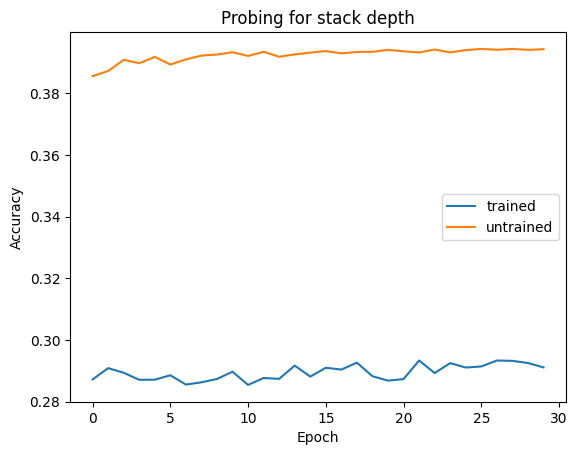

In [18]:
import matplotlib.pyplot as plt
plt.plot(acc, label="trained")
plt.plot(acc_untrained, label="untrained")
plt.title("Probing for stack depth")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# def visualize_representations(X, Y, title):
#     """
#     Visualize internal representations using t-SNE
    
#     Parameters:
#     X (numpy array): Internal representations
#     Y (numpy array): Stack depths
#     title (str): Plot title
#     """
#     # Convert to numpy if not already
#     X = np.array(X)
#     Y = np.array(Y)
    
#     # Perform t-SNE dimensionality reduction
#     tsne = TSNE(n_components=2, random_state=42)
#     X_tsne = tsne.fit_transform(X)
    
#     # Create a color map based on stack depths
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
#                           c=Y, 
#                           cmap='viridis', 
#                           alpha=0.7)
#     plt.colorbar(scatter, label='Stack Depth')
#     plt.title(f't-SNE Visualization: {title}')
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.tight_layout()
#     plt.show()

# # Visualize trained model representations
# visualize_representations(X, Y, 'Trained Model Representations')

# # Visualize untrained model representations
# visualize_representations(X_untrained, Y_untrained, 'Untrained Model Representations')

Epoch [1/30], Loss: 1.6857, Accuracy: 0.2703
Epoch [2/30], Loss: 2.1197, Accuracy: 0.2808
Epoch [3/30], Loss: 2.1036, Accuracy: 0.2770
Epoch [4/30], Loss: 1.5821, Accuracy: 0.2708
Epoch [5/30], Loss: 2.3489, Accuracy: 0.2713
Epoch [6/30], Loss: 2.2143, Accuracy: 0.2743
Epoch [7/30], Loss: 1.7172, Accuracy: 0.2729
Epoch [8/30], Loss: 2.3870, Accuracy: 0.2698
Epoch [9/30], Loss: 2.1382, Accuracy: 0.2717
Epoch [10/30], Loss: 1.7215, Accuracy: 0.2651
Epoch [11/30], Loss: 2.5211, Accuracy: 0.2693
Epoch [12/30], Loss: 1.9094, Accuracy: 0.2749
Epoch [13/30], Loss: 1.9710, Accuracy: 0.2699
Epoch [14/30], Loss: 1.5955, Accuracy: 0.2682
Epoch [15/30], Loss: 1.4644, Accuracy: 0.2767
Epoch [16/30], Loss: 1.9384, Accuracy: 0.2640
Epoch [17/30], Loss: 2.2879, Accuracy: 0.2620
Epoch [18/30], Loss: 2.8223, Accuracy: 0.2610
Epoch [19/30], Loss: 1.9639, Accuracy: 0.2659
Epoch [20/30], Loss: 2.0199, Accuracy: 0.2584
Epoch [21/30], Loss: 1.9548, Accuracy: 0.2564
Epoch [22/30], Loss: 2.4143, Accuracy: 0.25

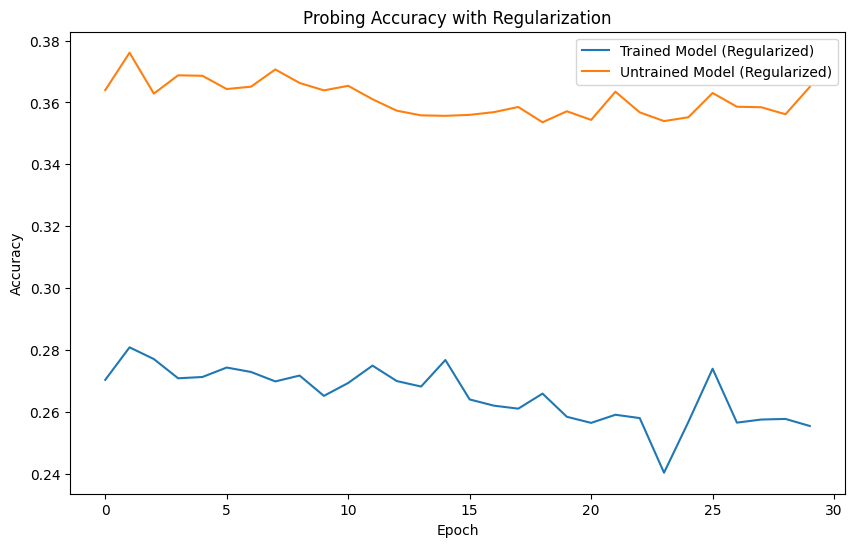

In [20]:
class RegularizedProbingClassifier(nn.Module):
    def __init__(self, input_size, output_size, 
                 l1_lambda=0.001, l2_lambda=0.001):
        """
        Probing classifier with L1 and L2 regularization
        
        Parameters:
        input_size (int): Size of input features
        output_size (int): Size of output (1 for stack depth)
        l1_lambda (float): L1 regularization strength
        l2_lambda (float): L2 regularization strength
        """
        super(RegularizedProbingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_size)
        
        # Regularization parameters
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
    def regularization_loss(self):
        """
        Calculate L1 and L2 regularization loss
        """
        l1_loss = 0
        l2_loss = 0
        
        for param in self.parameters():
            # L1 regularization (Lasso)
            l1_loss += torch.sum(torch.abs(param))
            # L2 regularization (Ridge)
            l2_loss += torch.sum(param ** 2)
        
        return self.l1_lambda * l1_loss + self.l2_lambda * l2_loss

# Training loop with regularization
def train_regularized_probing_classifier(X, Y, device, num_epochs=30, 
                                          l1_lambda=0.001, l2_lambda=0.001):
    # Prepare data
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device).unsqueeze(1)
    
    dataset = TensorDataset(X_tensor, Y_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Initialize model
    probing_model = RegularizedProbingClassifier(
        input_size=X_tensor.shape[1], 
        output_size=1, 
        l1_lambda=l1_lambda, 
        l2_lambda=l2_lambda
    ).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(probing_model.parameters(), lr=1e-3)
    
    # Training
    acc = []
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        probing_model.train()
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            
            # Standard loss
            outputs = probing_model(inputs)
            loss = criterion(outputs, targets)
            
            # Add regularization loss
            reg_loss = probing_model.regularization_loss()
            total_loss = loss + reg_loss
            
            total_loss.backward()
            optimizer.step()
            
            # Tracking metrics
            predicted = outputs.round()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        
        # Compute accuracy
        accuracy = correct / total
        acc.append(accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {total_loss.item():.4f}, "
              f"Accuracy: {accuracy:.4f}")
    
    return probing_model, acc

# Train on trained and untrained models
model_trained, acc_trained = train_regularized_probing_classifier(
    X, Y, device, l1_lambda=0.0001, l2_lambda=0.0001
)

model_untrained, acc_untrained = train_regularized_probing_classifier(
    X_untrained, Y_untrained, device, 
    l1_lambda=0.0001, l2_lambda=0.0001
)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(acc_trained, label='Trained Model (Regularized)')
plt.plot(acc_untrained, label='Untrained Model (Regularized)')
plt.title('Probing Accuracy with Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

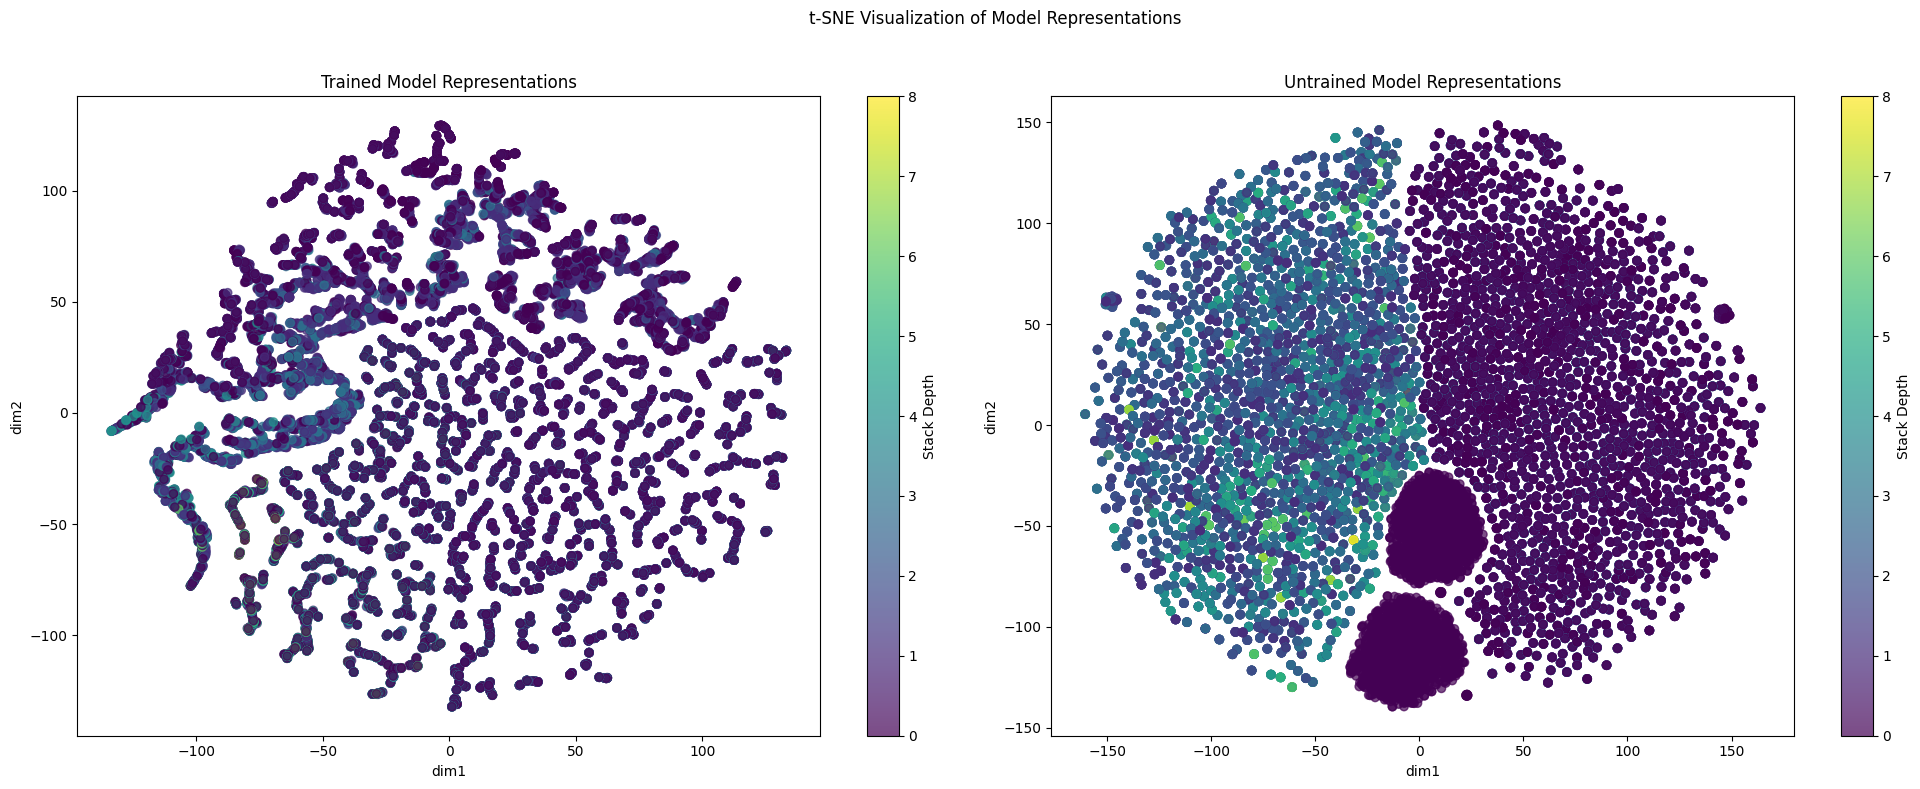

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_representations(X_trained, Y_trained, X_untrained, Y_untrained, title):
    """
    Visualize internal representations using t-SNE
    
    Parameters:
    X_trained (numpy array): Internal representations of the trained model
    Y_trained (numpy array): Stack depths for the trained model
    X_untrained (numpy array): Internal representations of the untrained model
    Y_untrained (numpy array): Stack depths for the untrained model
    title (str): Plot title
    """
    # Convert to numpy if not already
    X_trained = np.array(X_trained)
    Y_trained = np.array(Y_trained)
    X_untrained = np.array(X_untrained)
    Y_untrained = np.array(Y_untrained)
    
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    X_trained_tsne = tsne.fit_transform(X_trained)
    X_untrained_tsne = tsne.fit_transform(X_untrained)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot trained model representations
    scatter_trained = axes[0].scatter(X_trained_tsne[:, 0], X_trained_tsne[:, 1], 
                                      c=Y_trained, cmap='viridis', alpha=0.7)
    axes[0].set_title('Trained Model Representations')
    axes[0].set_xlabel('dim1')
    axes[0].set_ylabel('dim2')
    fig.colorbar(scatter_trained, ax=axes[0], label='Stack Depth')
    
    # Plot untrained model representations
    scatter_untrained = axes[1].scatter(X_untrained_tsne[:, 0], X_untrained_tsne[:, 1], 
                                        c=Y_untrained, cmap='viridis', alpha=0.7)
    axes[1].set_title('Untrained Model Representations')
    axes[1].set_xlabel('dim1')
    axes[1].set_ylabel('dim2')
    fig.colorbar(scatter_untrained, ax=axes[1], label='Stack Depth')
    
    # Set the main title
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
visualize_representations(X, Y, X_untrained, Y_untrained, 't-SNE Visualization of Model Representations')